In [18]:
# Install the required libraries
!pip install datasets optuna scikit-learn shap
!pip install xgboost==2.0.0

# Import necessary libraries
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import pandas as pd
import optuna
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from tabulate import tabulate
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import classification_report, precision_recall_fscore_support, f1_score, precision_recall_curve
from scipy.stats import skew, kurtosis, ttest_ind, chi2_contingency

In [19]:
# Load your dataset
dataset = load_dataset('Manisha12Researcher/hospital_mortality_data')

# Check the dataset structure
print("Dataset Structure:")
print(dataset)

# Display first few rows of the dataset for an overview
print("\nFirst 5 Rows of the Dataset:")
print(dataset['train'][:5])

# Convert to Pandas DataFrame
df = dataset['train'].to_pandas()

# List of variables to include in summary
variables = [
    'outcome', 'age', 'Anion gap', 'Lactic acid', 'Leucocyte', 'Urea nitrogen',
    'PT', 'Bicarbonate', 'Blood calcium', 'Lymphocyte',
    'Platelets'
]

# Filter the DataFrame for the selected variables
selected_df = df[variables]

# Summary statistics
summary_stats = selected_df.describe().drop(['25%', '50%', '75%'])

# Add a row for missing values (NAs)
summary_stats.loc['Missing'] = selected_df.isna().sum()

# Round numeric values to 2 decimals
summary_stats = summary_stats.round(2)

# Display the summary statistics with tabulate
print(tabulate(summary_stats, headers='keys', tablefmt='fancy_grid'))

Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['group', 'ID', 'outcome', 'age', 'gendera', 'BMI', 'hypertensive', 'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias', 'depression', 'Hyperlipemia', 'Renal failure', 'COPD', 'heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Respiratory rate', 'temperature', 'SP O2', 'Urine output', 'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte', 'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR', 'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen', 'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium', 'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate', 'Lactic acid', 'PCO2', 'EF'],
        num_rows: 1177
    })
})

First 5 Rows of the Dataset:
{'group': [1, 1, 1, 1, 1], 'ID': [125047, 139812, 109787, 130587, 138290], 'outcome': [0.0, 0.0, 0.0, 0.0, 0.0], 'age': [72, 75, 83, 43, 75], 'gendera': [1, 2, 2, 2, 2], 'BMI': [37.58817943,

In [20]:
# Remove missing values in the target variable
df = df.dropna(subset=['outcome'])

# Define the target variable and the feature variables
X = df.drop(columns=['outcome'])
y = df['outcome']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize StratifiedKFold with 5 splits
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store predictions and true values
all_y_true = []
all_y_pred = []

# Define Optuna's objective function with cross-validation
def objective_with_cv(trial):
    # Define hyperparameter search space
    params = {
        'objective': 'binary:logistic',
        'tree_method': 'hist',
        'device': 'cuda',
        'eval_metric': 'aucpr',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    f1_scores = []

    # Perform k-fold cross-validation
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Dynamically calculate scale_pos_weight
        scale_pos_weight = len(y_train_fold[y_train_fold == 0.0]) / len(y_train_fold[y_train_fold == 1.0])
        params['scale_pos_weight'] = scale_pos_weight

        # Train the model
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
        bst = xgb.train(params, dtrain, num_boost_round=100)

        # Predict and evaluate F1-score
        y_pred = bst.predict(dval)
        y_pred_binary = [1 if prob > 0.5 else 0 for prob in y_pred]
        f1_scores.append(f1_score(y_val_fold, y_pred_binary))

    # Return the mean F1-score across folds
    return np.mean(f1_scores)

# Run Optuna for hyperparameter tuning
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective_with_cv, n_trials=50)

print("Best parameters with CV:", study.best_params)


[I 2024-12-05 23:11:09,852] A new study created in memory with name: no-name-abd150a8-afbb-4771-912d-5605553d1f05
[I 2024-12-05 23:11:12,781] Trial 0 finished with value: 0.47656980056980053 and parameters: {'max_depth': 5, 'eta': 0.28570714885887566, 'gamma': 3.6599697090570253, 'min_child_weight': 6, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014}. Best is trial 0 with value: 0.47656980056980053.
[I 2024-12-05 23:11:16,075] Trial 1 finished with value: 0.42337282412566585 and parameters: {'max_depth': 3, 'eta': 0.2611910822747312, 'gamma': 3.005575058716044, 'min_child_weight': 8, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971}. Best is trial 0 with value: 0.47656980056980053.
[I 2024-12-05 23:11:17,390] Trial 2 finished with value: 0.4381120171817846 and parameters: {'max_depth': 9, 'eta': 0.07157834209670008, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378215816119}. 

Best parameters with CV: {'max_depth': 5, 'eta': 0.10244983765655452, 'gamma': 4.337679858738713, 'min_child_weight': 5, 'subsample': 0.7030681035984436, 'colsample_bytree': 0.6063151814651537}


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       204
         1.0       0.80      0.88      0.84        32

    accuracy                           0.95       236
   macro avg       0.89      0.92      0.90       236
weighted avg       0.96      0.95      0.95       236



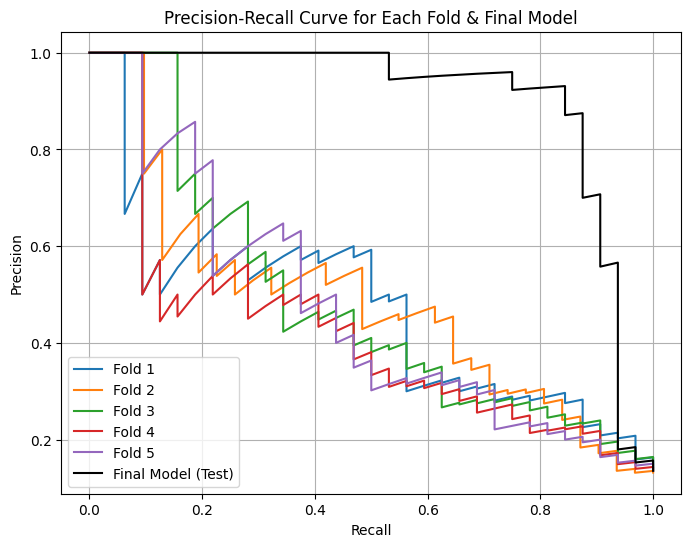

In [21]:
# Initialize XGBoost DMatrix for the test set
dtest = xgb.DMatrix(X_test, label=y_test)

# Set final parameters (updated with GPU-specific tree method and scale_pos_weight)
params = {
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'device': 'cuda',
    'eval_metric': 'aucpr',
    'max_depth': study.best_params['max_depth'],
    'eta': study.best_params['eta'],
    'gamma': study.best_params['gamma'],
    'min_child_weight': study.best_params['min_child_weight'],
    'subsample': study.best_params['subsample'],
    'colsample_bytree': study.best_params['colsample_bytree'],
}

# Initialize list to store precision-recall curves for each fold
fold_pr_curves = []

# Perform k-fold cross-validation with the tuned parameters
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Dynamically calculate scale_pos_weight
    scale_pos_weight = len(y_train_fold[y_train_fold == 0.0]) / len(y_train_fold[y_train_fold == 1.0])
    params['scale_pos_weight'] = scale_pos_weight

    # Convert data to DMatrix
    dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold)

    # Train the model
    bst = xgb.train(params, dtrain_fold, num_boost_round=100)

    # Predict on the validation fold
    y_pred_proba_fold = bst.predict(dval_fold)

    # Compute Precision-Recall curve for the fold
    precision_fold, recall_fold, thresholds_fold = precision_recall_curve(y_val_fold, y_pred_proba_fold)

    # Store the curve for comparison
    fold_pr_curves.append((precision_fold, recall_fold))

# After cross-validation, plot all fold Precision-Recall curves
plt.figure(figsize=(8, 6))
for fold, (precision_fold, recall_fold) in enumerate(fold_pr_curves):
    plt.plot(recall_fold, precision_fold, label=f'Fold {fold+1}')

# Final model test Precision-Recall curve
y_test_proba = bst.predict(dtest)  # Predict probabilities on the test set
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
plt.plot(recall, precision, color='black', label='Final Model (Test)')

threshold = 0.5
y_test_pred = (y_test_proba >= threshold).astype(int)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Fold & Final Model')
plt.legend()
plt.grid(True)
plt.show()

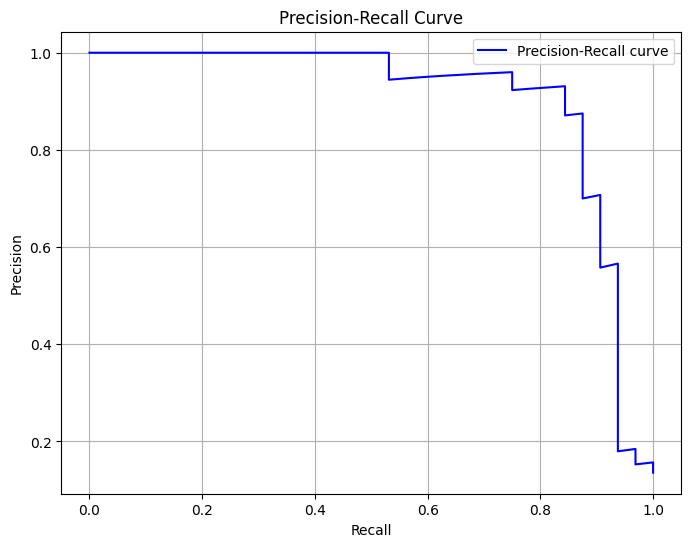

Classification Report After Threshold Tuning:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       204
         1.0       0.93      0.84      0.89        32

    accuracy                           0.97       236
   macro avg       0.95      0.92      0.93       236
weighted avg       0.97      0.97      0.97       236



In [23]:
# Get predicted probabilities for the test set
y_test_proba = bst.predict(dtest)

# Compute Precision-Recall curve and find the best threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_idx = f1_scores.argmax()
best_threshold = thresholds[best_threshold_idx]

# Use the best threshold to classify test predictions
y_pred_binary_best_threshold = (y_test_proba >= best_threshold).astype(int)

# Generate classification report
print("Classification Report After Threshold Tuning:")
print(classification_report(y_test, y_pred_binary_best_threshold))

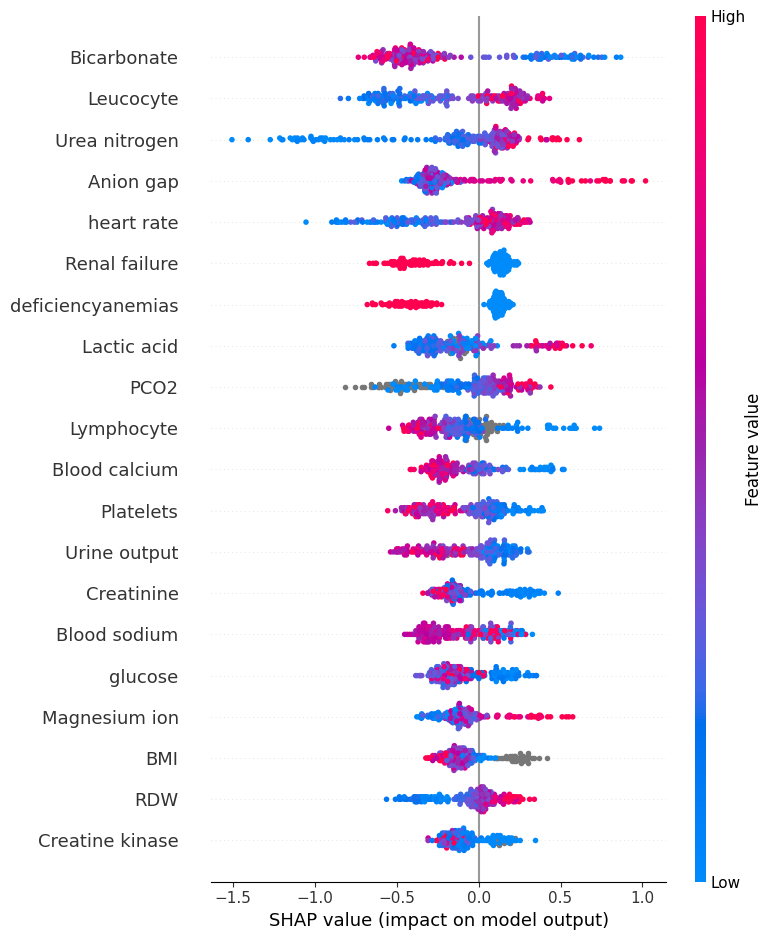

Top 10 Important Features:
              Feature  Importance
46        Bicarbonate    0.435611
27          Leucocyte    0.323365
37      Urea nitrogen    0.311212
43          Anion gap    0.307786
14         heart rate    0.268179
12      Renal failure    0.245765
9   deficiencyanemias    0.236668
47        Lactic acid    0.234989
48               PCO2    0.232408
31         Lymphocyte    0.202737


In [26]:
# Generate SHAP values
explainer = shap.TreeExplainer(bst)  # 'bst' is your trained XGBoost model
shap_values = explainer.shap_values(X_test)  # X_test is your test dataset

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="dot")  # Change to 'bar' if needed

# Calculate Feature Importance (Average Absolute SHAP Value)
shap_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': shap_importance
}).sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("Top 10 Important Features:")
print(importance_df.head(10))


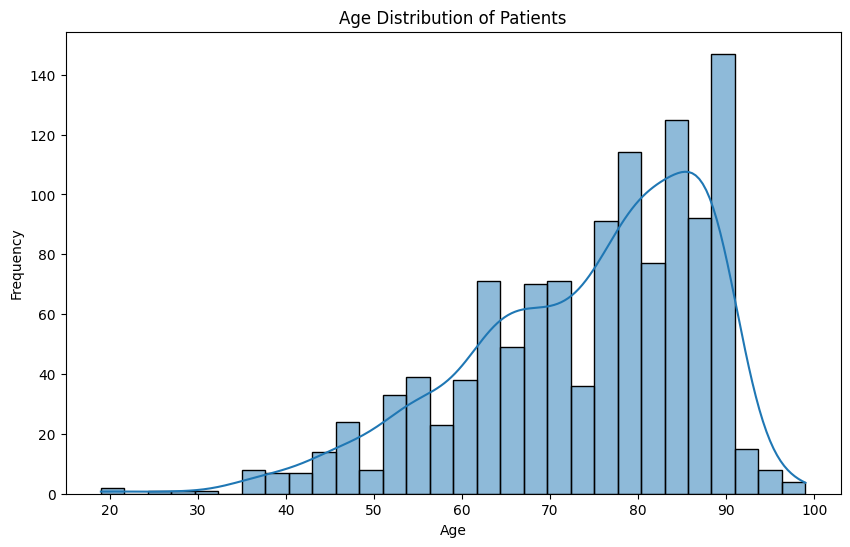

In [27]:
#Exploratory Data Analysis

# Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

outcome
0.0    0.864796
1.0    0.135204
Name: proportion, dtype: float64


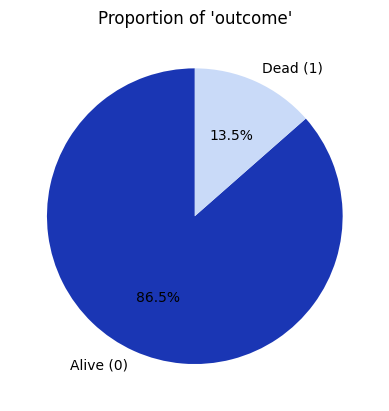

In [28]:
# Proportion of outcomes
outcome_proportion = df['outcome'].value_counts(normalize=True)
print(outcome_proportion)

# Pie chart for proportions
outcome_proportion.plot.pie(autopct='%1.1f%%', labels=['Alive (0)', 'Dead (1)'], startangle=90, colors=["#1a36b4", "#c9daf8"])
plt.title("Proportion of 'outcome'")
plt.ylabel("")  # Remove the y-axis label
plt.show()

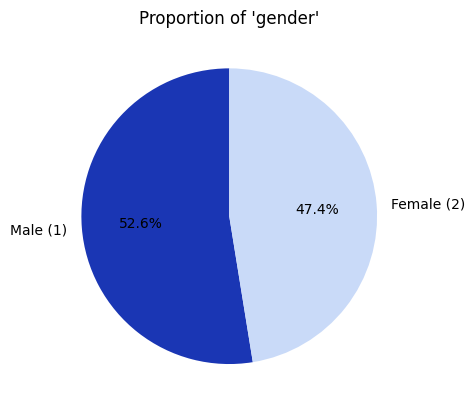

In [29]:
# Pie chart for proportions
gender_proportion.plot.pie(autopct='%1.1f%%', labels=['Male (1)', 'Female (2)'], startangle=90, colors=["#1a36b4", "#c9daf8"])
plt.title("Proportion of 'gender'")
plt.ylabel("")  # Remove the y-axis label
plt.show()

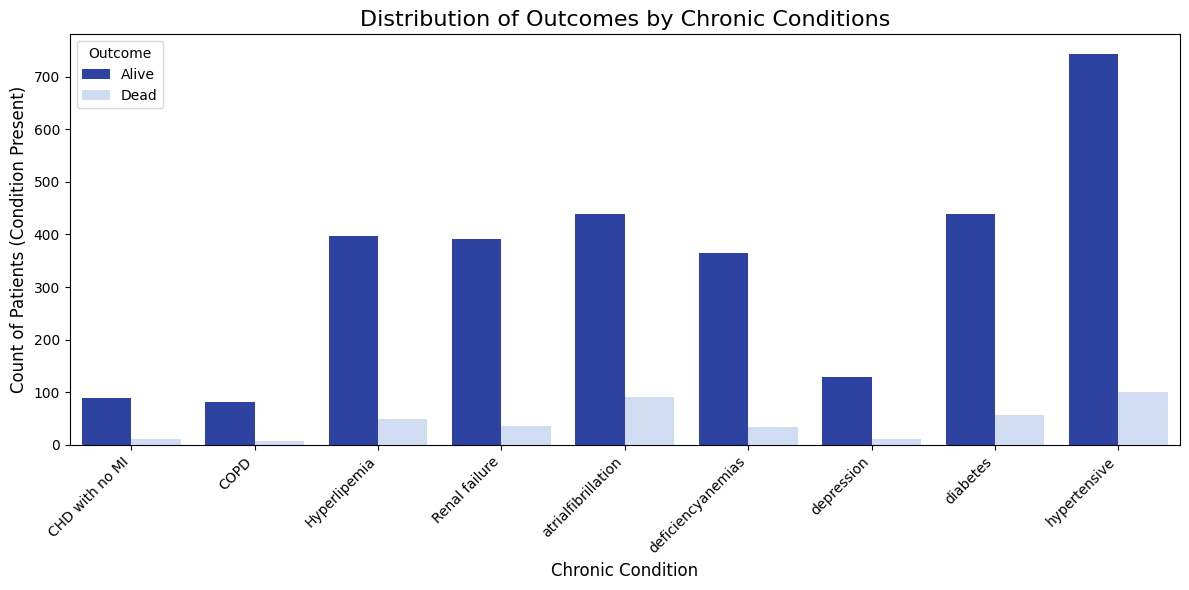

In [30]:
# Select only outcome and chronic conditions
chronic_conditions = [
    'hypertensive', 'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias', 'depression', 'Hyperlipemia', 'Renal failure', 'COPD'
]
df_subset = df.loc[:, ['outcome'] + chronic_conditions]

# Map the values of 'outcome' (0 = Alive, 1 = Dead)
df_subset['outcome'] = df_subset['outcome'].map({0: 'Alive', 1: 'Dead'})

# Convert to long format for plotting
long_df = pd.melt(
    df_subset,
    id_vars=['outcome'],
    value_vars=chronic_conditions,
    var_name='Chronic Condition',
    value_name='Status'
)

# Filter for Status = Present only
present_df = long_df[long_df['Status'] == 1]

# Count occurrences for each combination of 'outcome' and 'Chronic Condition'
grouped_df = present_df.groupby(['Chronic Condition', 'outcome']).size().reset_index(name='Count')

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped_df,
    x="Chronic Condition", y="Count", hue="outcome",
    palette=["#1a36b4", "#c9daf8"]  # Custom blue palette
)

# Customize labels and titles
plt.title("Distribution of Outcomes by Chronic Conditions", fontsize=16)
plt.xlabel("Chronic Condition", fontsize=12)
plt.ylabel("Count of Patients (Condition Present)", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()


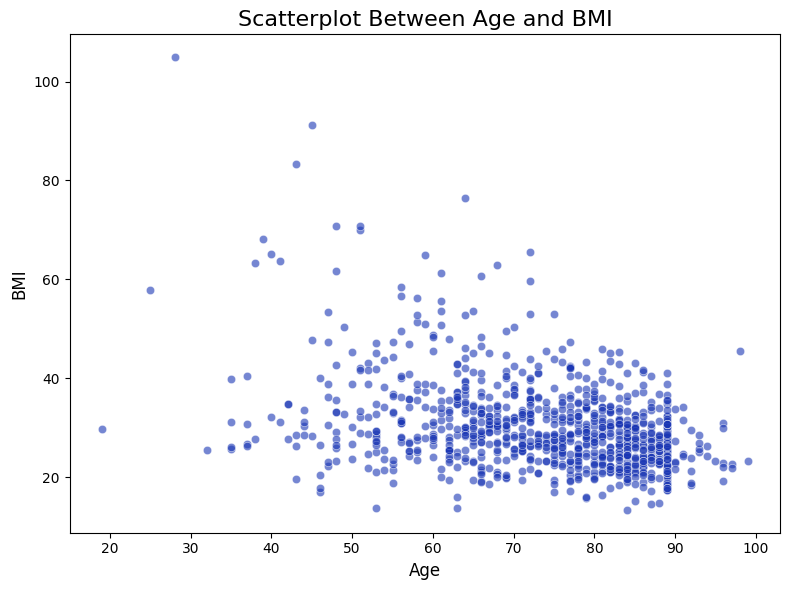

In [31]:
# Ensure 'age' and 'BMI' columns are present and drop any rows with missing values
df_clean = df[['age', 'BMI']].dropna()

# Create a scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='BMI', data=df_clean, color='#1a36b4', alpha=0.6)

# Add labels and title
plt.title("Scatterplot Between Age and BMI", fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("BMI", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [33]:
# Compute correlation of all numeric variables with 'outcome'
correlations = df.corr()['outcome'].sort_values(ascending=False)
print(correlations)

from scipy.stats import pointbiserialr

# Drop rows with missing values
df1 = df.dropna()

# Calculate Point-Biserial correlation
correlations = {}
for col in df1.select_dtypes(include=['float', 'int']).columns:
    if col != 'outcome':  # Skip the 'outcome' column itself
        corr, _ = pointbiserialr(df1['outcome'], df1[col])  # Get correlation value
        correlations[col] = corr


outcome                     1.000000
Lactic acid                 0.229695
Anion gap                   0.229676
Leucocyte                   0.208274
Urea nitrogen               0.203024
RDW                         0.148089
INR                         0.144444
PT                          0.140299
Blood potassium             0.136940
heart rate                  0.129750
NT-proBNP                   0.121075
Respiratory rate            0.117015
atrialfibrillation          0.100975
Creatine kinase             0.076656
Magnesium ion               0.074033
Neutrophils                 0.072177
age                         0.064510
Chloride                    0.059834
Creatinine                  0.046717
ID                          0.040398
MCV                         0.034144
glucose                     0.032436
MCH                         0.013387
CHD with no MI             -0.014694
hematocrit                 -0.016533
gendera                    -0.022690
RBC                        -0.023992
E

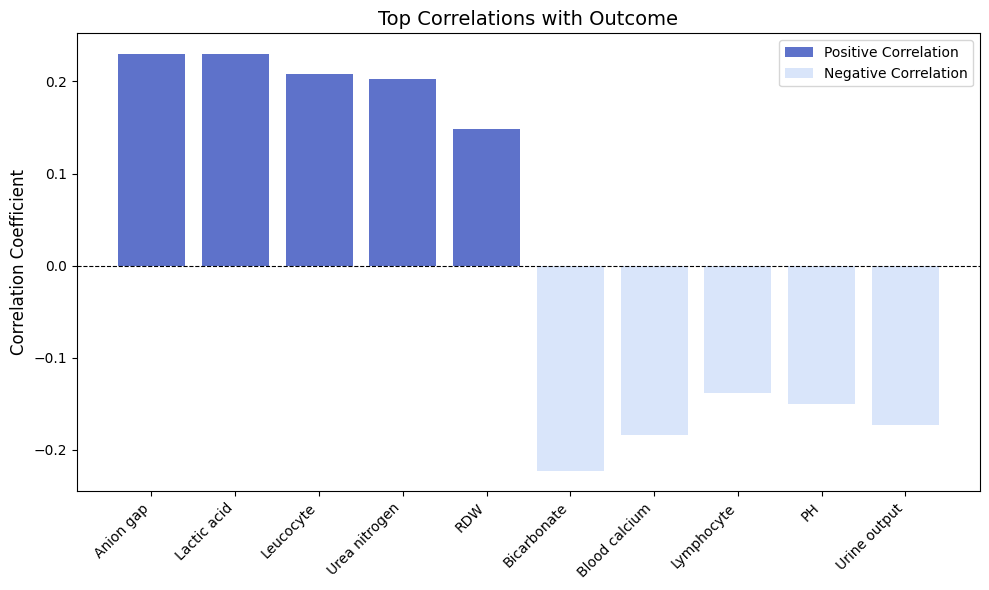

In [34]:
# Data for correlations
correlations = {
    'Anion gap': 0.229676, 'Lactic acid': 0.229695,
    'Leucocyte':  0.208274, 'Urea nitrogen':  0.203024,
    'RDW': 0.148089, 'Bicarbonate':  -0.222650,
    'Blood calcium': -0.184071, 'Lymphocyte':-0.138936,
    'PH': -0.150611, 'Urine output':-0.173135
}

# Split into positive and negative correlations for clarity
positive_corr = {k: v for k, v in correlations.items() if v > 0}
negative_corr = {k: v for k, v in correlations.items() if v < 0}

# Create the bar chart
plt.figure(figsize=(10, 6))

# Plot positive correlations
plt.bar(positive_corr.keys(), positive_corr.values(), color="#1a36b4", alpha=0.7, label='Positive Correlation')

# Plot negative correlations
plt.bar(negative_corr.keys(), negative_corr.values(), color="#c9daf8", alpha=0.7, label='Negative Correlation')

# Add labels, title, and legend
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Top Correlations with Outcome', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


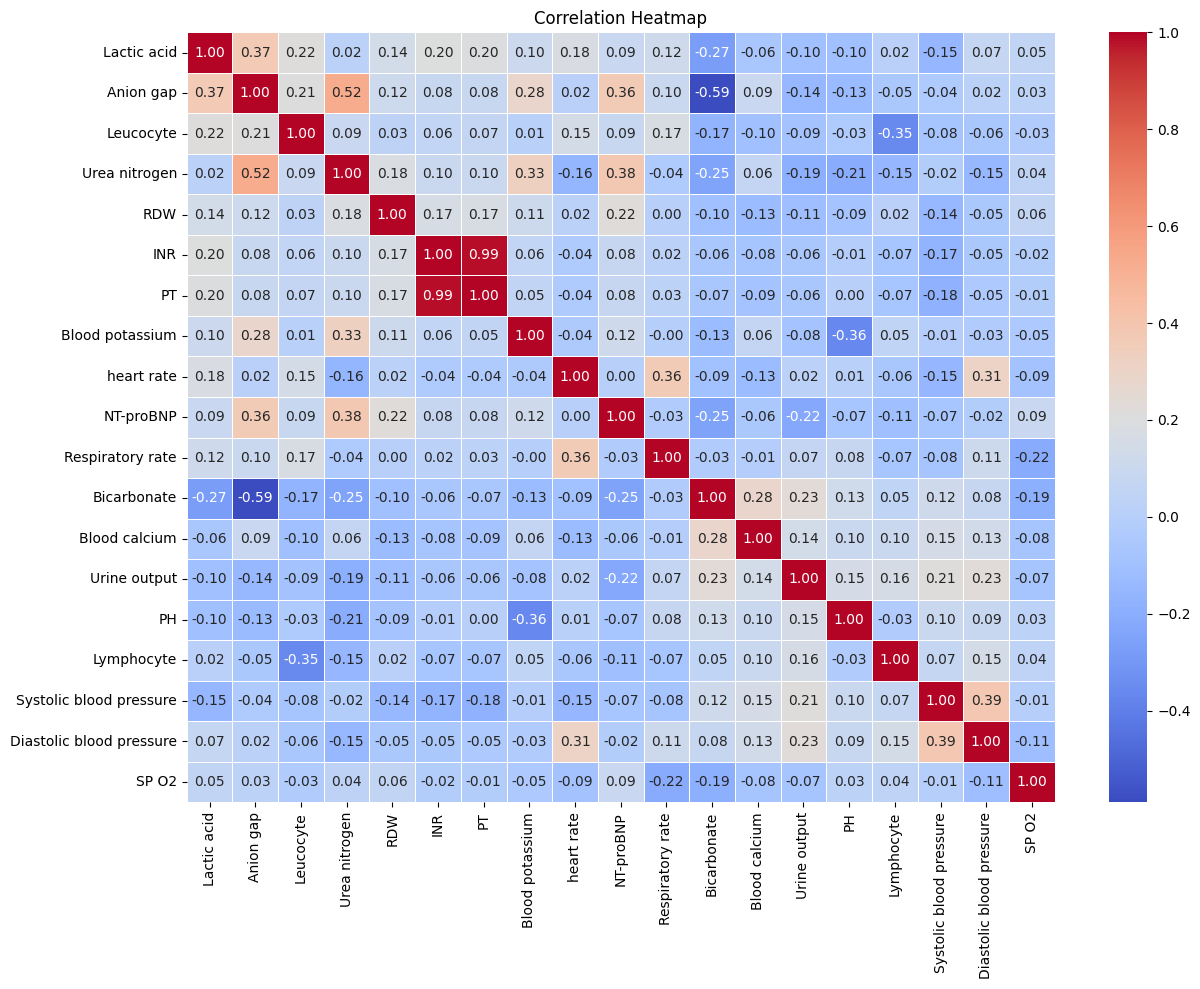

TypeError: unhashable type: 'list'

<Figure size 1400x1000 with 0 Axes>

In [36]:
# Select numeric variables for correlation

plt.figure(figsize=(14, 10))
corr = df[selected_vars].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Select numeric variables and include 'outcome'
selected_vars1 = ['outcome'] + [selected_vars]

# Calculate the correlation
plt.figure(figsize=(14, 10))
corr = df[selected_vars1].corr()

# Plot the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap with Outcome')
plt.show()
